In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')
import sys 
import os
sys.path.append('/'.join(os.getcwd().split('/')[:4]))
from config.get import cfg
from tensorflow import keras
from tensorflow.keras import layers
import autoencoders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loaidng data

In [89]:
X_train = np.load(cfg['files']["raw_train_features"])
X_test  = np.load(cfg['files']["raw_test_features"])
print(f"shapes : X_train={X_train.shape},X_test={X_test.shape}")

shapes : X_train=(5354, 3, 600, 2),X_test=(1340, 3, 600, 2)


# Loading model

In [98]:
def linear():
    model_name = "linear"
    in_shape = (3,600, 2) 
    # build encoder
    input_layer = keras.Input(shape=in_shape)
    x = layers.Reshape([in_shape[0]*in_shape[1]*in_shape[2]])(input_layer)
    x = layers.Dense(100,  activation='elu')(x)
    x = layers.Dense(100,  activation='linear')(x)
    x = layers.Dense(100,  activation='elu')(x)
    x = layers.Dense(in_shape[0]*in_shape[1]*in_shape[2],  activation='linear')(x)
    output_layer =layers.Reshape(in_shape)(x)
    
    
    # combine encoder and decoder
    autoencoder = keras.Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',)
    return model_name ,autoencoder

model_name,autoencoder = linear()
autoencoder.summary()
train_loss = []
test_loss = []

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 3, 600, 2)]       0         
                                                                 
 reshape_36 (Reshape)        (None, 3600)              0         
                                                                 
 dense_64 (Dense)            (None, 100)               360100    
                                                                 
 dense_65 (Dense)            (None, 100)               10100     
                                                                 
 dense_66 (Dense)            (None, 100)               10100     
                                                                 
 dense_67 (Dense)            (None, 3600)              363600    
                                                                 
 reshape_37 (Reshape)        (None, 3, 600, 2)         0  

In [99]:
hist = autoencoder.fit(X_train, X_train,epochs=50,validation_data=(X_test, X_test))

Epoch 1/50
168/168 [==============================] - 5s 28ms/step - loss: 0.3573 - val_loss: 0.5516
Epoch 2/50
168/168 [==============================] - 4s 26ms/step - loss: 0.1829 - val_loss: 0.4901
Epoch 3/50
168/168 [==============================] - 4s 26ms/step - loss: 0.1519 - val_loss: 0.4605
Epoch 4/50
168/168 [==============================] - 4s 25ms/step - loss: 0.1381 - val_loss: 0.4468
Epoch 5/50
168/168 [==============================] - 4s 25ms/step - loss: 0.1306 - val_loss: 0.4259
Epoch 6/50
168/168 [==============================] - 4s 25ms/step - loss: 0.1237 - val_loss: 0.4199
Epoch 7/50
168/168 [==============================] - 4s 26ms/step - loss: 0.1196 - val_loss: 0.4100
Epoch 8/50
168/168 [==============================] - 4s 25ms/step - loss: 0.1164 - val_loss: 0.4051
Epoch 9/50
168/168 [==============================] - 4s 25ms/step - loss: 0.1148 - val_loss: 0.4003
Epoch 10/50
168/168 [==============================] - 4s 25ms/step - loss: 0.1144 - val_lo

In [100]:
train_loss += hist.history["loss"]
test_loss  += hist.history["val_loss"]

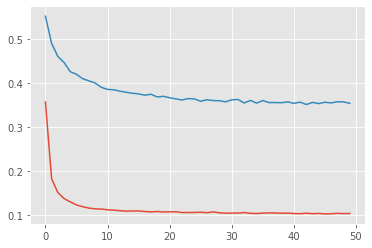

In [101]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

# Saving 

In [29]:
autoencoder.save(cfg["models"]["autoencoder"] + f"{model_name}")

In [30]:
np.save(file = cfg["models"]["autoencoder"]+ f"{model_name}_train_loss", arr = np.array(train_loss))
np.save(file = cfg["models"]["autoencoder"]+ f"{model_name}_test_loss", arr = np.array(test_loss))

In [ ]:
from sklearn import decomposition

N_train = len(X_train)
N_test  = len(X_test)
tX_train = X_train.reshape(N_train,-1)
tX_test = X_test.reshape(N_test,-1)

def eval_PCA(n_components=100):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(tX_train)
    pca_train = mean_squared_error(tX_train, pca.inverse_transform(pca.transform(tX_train)))
    pca_test =  mean_squared_error(tX_test, pca.inverse_transform(pca.transform(tX_test))) 
    return pca_train,pca_test

pca_train,pca_test = eval_PCA()
print(f"MSE train : {pca_train} \nMSE test  : {pca_test}")